In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv
/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv


In [2]:
# import libraries
import numpy as np
import pandas as pd 
import tensorflow as tf
from dateutil.parser import parse
dateparse=lambda dates:parse(dates)
import matplotlib.pyplot as plt

In [3]:
# load data from csv file and parse dates 
train_data = pd.read_csv('../input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv',
                         parse_dates=['date'],date_parser=dateparse)
train_data

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [4]:
test_data = pd.read_csv('../input/daily-climate-time-series-data/DailyDelhiClimateTest.csv',
                         parse_dates=['date'],date_parser=dateparse)
test_data

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333
...,...,...,...,...,...
109,2017-04-20,34.500000,27.500000,5.562500,998.625000
110,2017-04-21,34.250000,39.375000,6.962500,999.875000
111,2017-04-22,32.900000,40.900000,8.890000,1001.600000
112,2017-04-23,32.875000,27.500000,9.962500,1002.125000


In [5]:
# check cloumn data types
print(train_data.dtypes)
print(test_data.dtypes)

date            datetime64[ns]
meantemp               float64
humidity               float64
wind_speed             float64
meanpressure           float64
dtype: object
date            datetime64[ns]
meantemp               float64
humidity               float64
wind_speed             float64
meanpressure           float64
dtype: object


In [6]:
# convert data and menatemp column into numpy arraies for both test and training dfs
train_series = np.array(train_data.meantemp)
train_time = np.array(train_data.date)
test_series = np.array(test_data.meantemp)
test_time = np.array(test_data.date)

In [7]:
# print shapes 
print(train_series.shape)
print(test_series.shape)
print(train_time.shape)
print(test_time.shape)

(1462,)
(114,)
(1462,)
(114,)


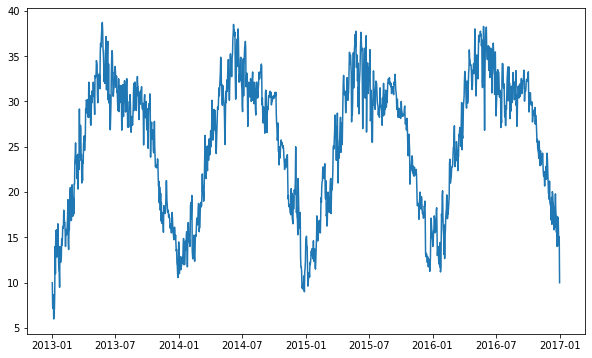

In [8]:
# plot meantep and date columns 
plt.figure(figsize=(10, 6))
plt.plot(train_time,train_series)
plt.show()

In [9]:
window_size = 33 # 33 time steps that will be used as features to predict the next time step in the time series 
batch_size = 50 # the number of training examples in one forward/backward pass throught the network.
                # 1000/50 = 20 groups of 50 will be proagated throught the network 
shuffle_buffer_size = 500 # shuffle data so that its not in any order 

In [10]:
# convert dataset into training data that the model can use

# function inputs: data series, size of the window,The size of the batches to use when training,
# the size of the shuffle buffer, which determines how the data will be shuffled.
# Expand the dimensions of the series
# Create dataset ds from the series
# Slice the data up into the appropriate windows, shifted by one time set.
# keep them all the same size by setting drop remainder to true.
# flatten the data into numpy array in the size of our window_size + 1.
# shuffle data so that its not in order
# than split data into features and labels  

def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer_size)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [11]:
# helper function that can preform forecasting after training model
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(50).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [12]:
# used to find the optimum learning rate for the optimizer (form of hyperparameter tuning) using conv1D, LSTM, and dense layer
tf.keras.backend.clear_session() # this helps avoid clutter from old models and layers
tf.random.set_seed(51)  # to get reproducable results 
np.random.seed(51)  # generate pseudo-random numbers 

train_set = windowed_dataset(train_series, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(train_series.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100) # scale outputs by 100 using lambda layer 
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)) # to tune the learning rate set up a callback 

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(1462,)


2022-01-25 08:34:43.672715: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
29/29 [==============================] - 7s 70ms/step - loss: 28.2614 - mae: 28.7614
Epoch 2/100
29/29 [==============================] - 2s 70ms/step - loss: 27.8850 - mae: 28.3850
Epoch 3/100
29/29 [==============================] - 2s 68ms/step - loss: 27.4286 - mae: 27.9286
Epoch 4/100
29/29 [==============================] - 2s 72ms/step - loss: 26.9119 - mae: 27.4119
Epoch 5/100
29/29 [==============================] - 2s 70ms/step - loss: 26.3226 - mae: 26.8226
Epoch 6/100
29/29 [==============================] - 2s 70ms/step - loss: 25.6270 - mae: 26.1270
Epoch 7/100
29/29 [==============================] - 2s 68ms/step - loss: 24.7913 - mae: 25.2913
Epoch 8/100
29/29 [==============================] - 2s 72ms/step - loss: 23.8507 - mae: 24.3507
Epoch 9/100
29/29 [==============================] - 2s 69ms/step - loss: 22.9428 - mae: 23.4428
Epoch 10/100
29/29 [==============================] - 2s 70ms/step - loss: 22.0562 - mae: 22.5562
Epoch 11/100
29/29 [=========

(1e-08, 0.001, 0.0, 30.0)

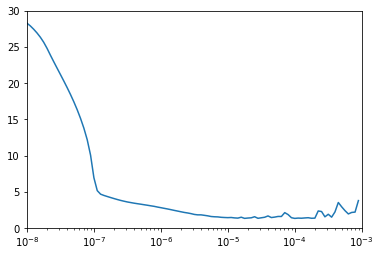

In [13]:
# plot the learning rate loss 
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 30])

In [14]:
# optimum learning rate found was headed towards 1e-4 
tf.keras.backend.clear_session() # this helps avoid clutter from old models and layers
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(train_series, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=100)

Epoch 1/100
29/29 [==============================] - 6s 59ms/step - loss: 7.7141 - mae: 8.2000
Epoch 2/100
29/29 [==============================] - 2s 61ms/step - loss: 3.3567 - mae: 3.8299
Epoch 3/100
29/29 [==============================] - 2s 64ms/step - loss: 2.0627 - mae: 2.5202
Epoch 4/100
29/29 [==============================] - 2s 61ms/step - loss: 2.1129 - mae: 2.5718
Epoch 5/100
29/29 [==============================] - 2s 59ms/step - loss: 1.9388 - mae: 2.3941
Epoch 6/100
29/29 [==============================] - 2s 60ms/step - loss: 2.3005 - mae: 2.7636
Epoch 7/100
29/29 [==============================] - 2s 61ms/step - loss: 2.2732 - mae: 2.7348
Epoch 8/100
29/29 [==============================] - 2s 62ms/step - loss: 1.6883 - mae: 2.1389
Epoch 9/100
29/29 [==============================] - 2s 63ms/step - loss: 1.5841 - mae: 2.0304
Epoch 10/100
29/29 [==============================] - 2s 60ms/step - loss: 1.5678 - mae: 2.0138
Epoch 11/100
29/29 [=============================

In [15]:
window_size = 1
forecast = model_forecast(model, test_series[..., np.newaxis], window_size)
forecast = forecast[window_size:-1, -1, 0]
print(forecast.shape)

(112,)


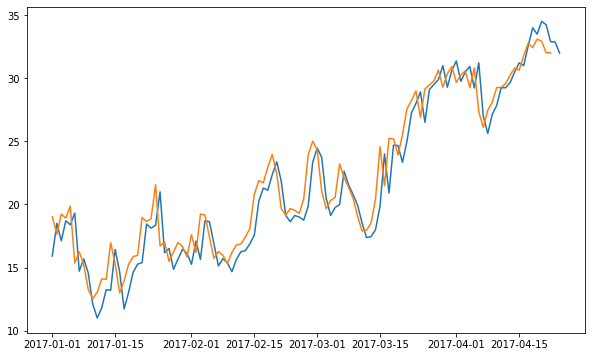

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(test_time, test_series) #  plot test time and its corrsponding meantep as test_series
plt.plot(test_time[:112], forecast) #  plot test time first 112 and the predicted meantep 
plt.show()

In [17]:
print("First 7 Predictions :","\n", forecast[:7])
print('')
print('Actual first 7 values:', "\n", test_series[:7])

First 7 Predictions : 
 [19.027834 17.631493 19.231213 18.915024 19.86177  15.348058 16.24744 ]

Actual first 7 values: 
 [15.91304348 18.5        17.11111111 18.7        18.38888889 19.31818182
 14.70833333]


In [18]:
print('Mean absolute error:')
tf.keras.metrics.mean_absolute_error(test_series[:112], forecast).numpy()

Mean absolute error:


1.3984083

In [19]:
# predictions on the left and actual values on the right 
m_p = pd.Series(forecast,test_series[:112])
m_p

15.913043    19.027834
18.500000    17.631493
17.111111    19.231213
18.700000    18.915024
18.388889    19.861771
               ...    
34.000000    32.436199
33.500000    33.097183
34.500000    32.934883
34.250000    32.024372
32.900000    32.006962
Length: 112, dtype: float32